# Regression

## Linear Regression

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
    
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [2]:
import matplotlib.pyplot as plt

# Generate some data points on a straight line perturbed with Gaussian noise according to 𝑦=1.5𝑥+2

N = 1000 # number of points
theta_true = torch.Tensor([[1.5], [2.0]]) # true parameters of the line
# theta_true = torch.Tensor([[2.0], [1.5]]) # true parameters of the line

X = torch.rand(N, 2) 
# X[:, 1] = 1.0
X[:, 0] = 1.0
y = X @ theta_true + 0.1 * torch.randn(N, 1)


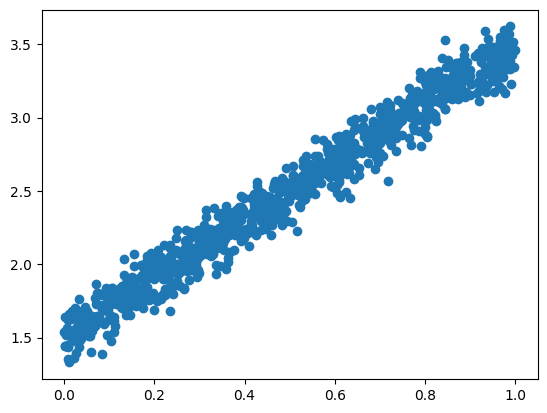

In [3]:
# plt.scatter(X[:,0].numpy(), y.numpy())
plt.scatter(X[:,1].numpy(), y.numpy())
plt.show()

### Computing the pseudo invers form the SVD

In [4]:
#manualy

U,S,V = torch.linalg.svd(X, full_matrices=False)
S_inv = 1/S
X_inv_svd = V.t() @ torch.diag(S_inv) @ U.t()
theta_pinv_svd = torch.mm(X_inv_svd, y)
# theta_pinv_svd,
torch.nn.functional.mse_loss(X @ theta_pinv_svd, y)

tensor(0.0103)

In [5]:
X_pseudo_inv = torch.linalg.inv(X.t() @ X) @ X.t()

X_inv_svd @ y, X_pseudo_inv @ y
torch.nn.functional.mse_loss(X @ X_inv_svd @ y, y), torch.nn.functional.mse_loss(X @ X_pseudo_inv @ y, y)

(tensor(0.0103), tensor(0.0103))

In [6]:
#using moore-penrose pseudo inverse

X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, y)

theta_pinv,torch.nn.functional.mse_loss(X @ theta_pinv, y)

(tensor([[1.5096],
         [1.9738]]),
 tensor(0.0103))

### Gradinat based Linear Regression

We want to minimises $f(\theta) = 0.5\|\mathbf{X}\theta - \mathbf{y}\|_2^2$.

It's gradiant is : $f'(θ)= 0.5 * 2* \mathbf{X}^T(\mathbf{X}θ-y) $

In [28]:
def grad_fn(X, y, theta):
    grad = 0.5* 2 * X.t()@(X@theta-y)
    return grad

def gradiantDescent(X, y, rate, theta, epoch, grd_fn):
    for e in range(0, epoch):
        gr = grd_fn(X, y, theta)
        theta -= rate * gr
    return theta

In [8]:
theta = torch.Tensor([[0], [0]])
theta = gradiantDescent(X,y,0.001,theta, 200, grad_fn)

theta, torch.nn.functional.mse_loss(X @ theta, y)


(tensor([[1.5096],
         [1.9738]]),
 tensor(0.0103))

In [9]:
from sklearn.datasets import load_diabetes

Data = tuple(torch.Tensor(z) for z in load_diabetes(return_X_y=True)) #convert to pytorch Tensors
X, y = Data[0], Data[1]
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
y = y.reshape(-1, 1)

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:253], :]
y_train = y[perm[0:253]]
X_test = X[perm[253:], :]
y_test = y[perm[253:]]

In [10]:
X_inv = torch.pinverse(X_train)
theta_pinv = torch.mm(X_inv,y_train)
# print(theta_pinv)
pinv_mse = torch.nn.functional.mse_loss(X_test @ theta_pinv,y_test)
print(pinv_mse)

tensor(3240.9758)


Text(0.5, 1.0, 'Plot of the Mean Square Error of Gradient Decent related to the smple size')

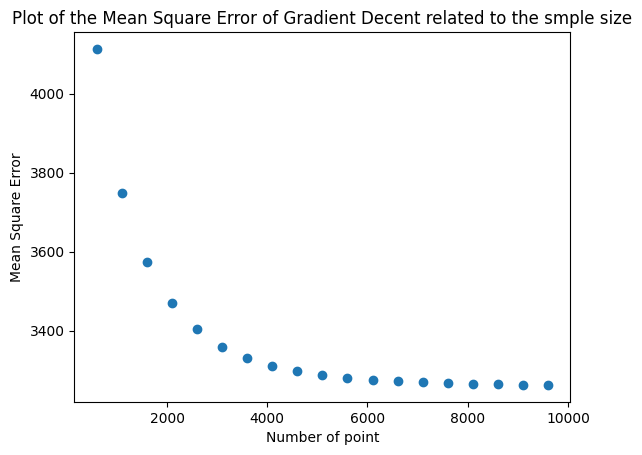

In [11]:
losses = torch.empty(20)
for e in range(100, 10000, 500):
    thetaInit = torch.rand((X_train.shape[1], 1))
    theta = gradiantDescent(X_train, y_train, 0.001, thetaInit, e, grad_fn)
    losses[int(e/500)] =torch.nn.functional.mse_loss(X_test @ theta, y_test) 

fig = plt.subplot()
plt.scatter(range(100, 10000, 500)[1:],losses[1:])
plt.xlabel("Number of point")
plt.ylabel("Mean Square Error")
plt.title("Plot of the Mean Square Error of Gradient Decent related to the smple size")

## Real data

Doing linear regression on synthetic data is a great way to understand how PyTorch works, but it isn't quite as satisfying as working with a real dataset. Let's now apply or understanding of computing linear regression parameters to a dataset of Diabetes.

We'll load the dataset using scikit-learn and perform some manipulations in the following code block:

In [25]:
from sklearn.datasets import load_diabetes

Data = tuple(torch.Tensor(z) for z in load_diabetes(return_X_y=True)) #convert to pytorch Tensors
X, y = Data[0], Data[1]
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
y = y.reshape(-1, 1) # reshape y into a column vector
print('X:', X.shape)
print('y:', y.shape)

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:253], :]
y_train = y[perm[0:253]]
X_test = X[perm[253:], :]
y_test = y[perm[253:]]

X: torch.Size([442, 11])
y: torch.Size([442, 1])


Solve using the psudo inverse

In [26]:
X_inv = torch.pinverse(X_train)
theta = torch.mm(X_inv, y_train)
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta, y_test))
print("Theta: ", theta.t())

MSE of test data:  tensor(2755.9844)
Theta:  tensor([[  27.3780, -210.1327,  488.0018,  324.5588, -712.3106,  507.3327,
           55.5309,   72.5008,  764.4833,   90.8474,  151.6447]])


Solve using gradiant descent

In [31]:
reat = 0.001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 100000):
    gr = grad_fn( X_train, y_train, theta_gd)
    theta_gd -= reat * gr

print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))
print("Gradient Descent Theta: ", theta_gd.t())

MSE of test data:  tensor(2769.0801)
Gradient Descent Theta:  tensor([[  27.0138, -209.4123,  488.7954,  322.9462, -251.8018,  147.3959,
         -156.8582,    4.6002,  598.6140,   90.7179,  151.6275]])


Study into how the learning rate affect performance

In [83]:
lrs = [.0001, .001, .005, .01, .1]
losses =[]
for rate in lrs:
    theta_gd = torch.rand((X_train.shape[1], 1))
    for e in range(0, 100000):
        gr = grad_fn( X_train, y_train, theta_gd)
        theta_gd -= rate * gr
    # print(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))
    losses.append(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

In [87]:
print(lrs, "\n", losses)

[0.0001, 0.001, 0.005, 0.01, 0.1] 
 [tensor(2773.8208), tensor(2769.0752), tensor(2756.9104), tensor(nan), tensor(nan)]


The conclusion from this is that the optimal learning rate is somewhere between 0.001 and 0.01.

In [92]:
lrs = [x/1000.0 for x in range(1, 10)]
losses =[]
for rate in lrs:
    theta_gd = torch.rand((X_train.shape[1], 1))
    for e in range(0, 100000):
        gr = grad_fn( X_train, y_train, theta_gd)
        theta_gd -= rate * gr
    # print(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))
    losses.append(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Text(0, 0.5, 'MSE Loss')

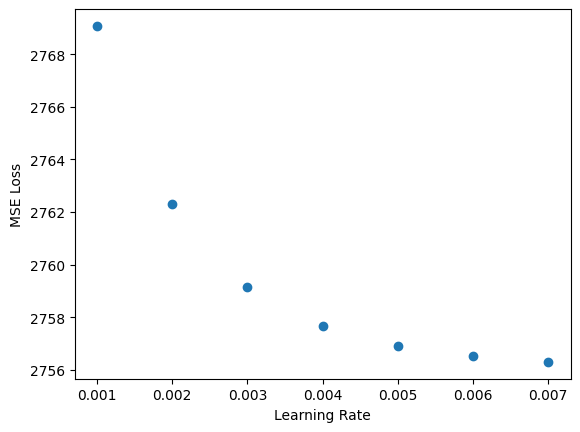

In [93]:
plt.scatter(lrs, losses)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")


In [94]:
print(losses)

[tensor(2769.0793), tensor(2762.3235), tensor(2759.1624), tensor(2757.6626), tensor(2756.9104), tensor(2756.5132), tensor(2756.3015), tensor(nan), tensor(nan)]


So a lr bigger than 0.007 does not converge and smaller lr start overfitting.

Now we explore the effect the no of itterations has on the perfomrance

In [101]:
epochs = range(1000, 100000, 1000)
reat = 0.001
losses = []
theta_gd = torch.rand((X_train.shape[1], 1))
for epoch in epochs:
    for e in range(0, epoch):
        gr = grad_fn( X_train, y_train, theta_gd)
        theta_gd -= reat * gr
    losses.append(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Text(0, 0.5, 'MSE Loss')

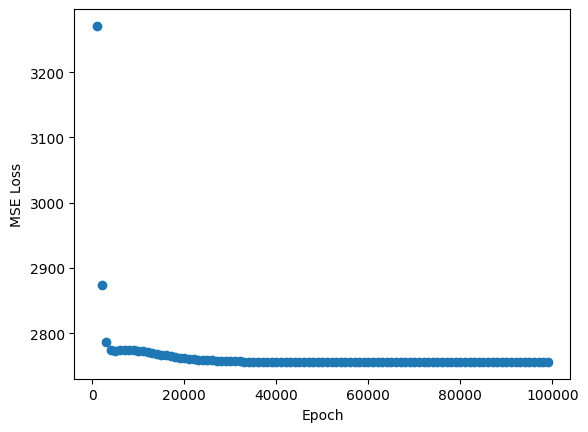

In [102]:
plt.scatter(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

Text(0, 0.5, 'MSE Loss')

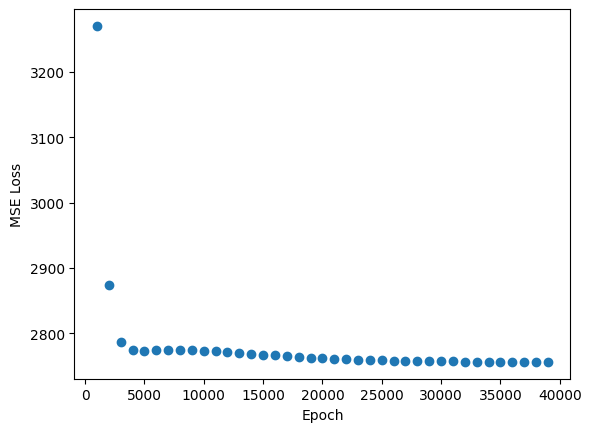

In [103]:
epochs = range(1000, 40000, 1000)
reat = 0.001
losses = []
theta_gd = torch.rand((X_train.shape[1], 1))
for epoch in epochs:
    for e in range(0, epoch):
        gr = grad_fn( X_train, y_train, theta_gd)
        theta_gd -= reat * gr
    losses.append(torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

plt.scatter(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

More than 5000 is useless as there is no much imporvment.

## Regression on non-linear data

In [12]:
import numpy as np # numerical computation packages in python
import matplotlib.pyplot as plt # plotting routines
from sklearn.model_selection import train_test_split

In [13]:
def f(x):
  return torch.exp(-x/2) * torch.sin(np.pi*x) + torch.sin((3*np.pi*x)/2)

def gaussian_basis_fn(x, mu, sigma=0.1):
  return torch.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def polynomialFunction(x, degree):
  poly = 0
  for j in range(0, degree+1):
      poly+= x ** j
  return poly

def make_design(x, basisfn, basisfn_locs=None):
  if basisfn_locs is None:
    return torch.cat([torch.ones(x.shape), basisfn(x)], axis=1)
  else:
    return torch.cat([torch.ones(x.shape)] + \
[basisfn(x, loc) for loc in basisfn_locs], axis=1)

#mean square loss function
def meanSqLoss(A,y,wt):
  return torch.mean((A.dot(wt) - y) ** 2)

#root mean square loss function
def rmse(A,y,wt):
  n= A.shape
  return torch.sqrt(meanSqLoss(A,y,wt)/n[0])

#gradient square loss function
def gradSqLoss(A,y,wt):
  n= A.shape
  return (-2/n[0])*A.T.dot((y-A.dot(wt)))

#gradient descent
def gradientdescent(A, Y, wInit, rate, numiter):
    wHistory = []
    meanrRSSHistory = []
    w = wInit

    for i in range(numiter):
        meanRSS = np.square(Y - A.dot(w)).mean
        wHistory.append(w)
        meanrRSSHistory.append(meanRSS)
        grad = gradSqLoss(A,Y,w)
        w = w - rate*grad
    return w


"""""
function that performs Ridge Regression

A - design matrix
lam - regularization term
p - degree of plinomial
Y - target vector
"""

def regression(A, lam, p, Y):
  I = torch.eye(p + 1) #identity matrix
  pseudoInv = torch.linalg.inv(torch.add(A.T.mm(A), lam * I)).mm(A.T)
  return pseudoInv @ Y

In [14]:
N = 30 #no. of poitns
# p = 9 #degree of polinomial aka no of waits
X = torch.linspace(-2,2,N) #points

np.random.seed(5)
rn = torch.randint(-1,1,(N,)) #noise
x = torch.reshape(torch.sort(rn, axis = 0)[0], (N,1))
# weight = np.random.normal(0,1,p+1) #random starting weights

trainingX, testingX = train_test_split(X, test_size= 10, train_size= 20, random_state=42)
trainingX = torch.sort(trainingX)[0]
testingX = torch.sort(testingX)[0]
trainingY = f(trainingX) + torch.randint(-1,1,(20,))
testingY = f(testingX) + torch.randint(-1,1,(10,))


In [17]:
losses = []

for p in range(1, 20, 3):

    A = make_design(torch.reshape(trainingX, (20, 1)), gaussian_basis_fn, torch.linspace(-2,2,p))
    lam = 0 #regularization parameter
    
    theta = regression(A, lam, p, trainingY)
    predictions = A @ theta.T
    losses.append(torch.nn.functional.mse_loss(predictions,trainingY))
print(losses)

[tensor(2.1363), tensor(1.7324), tensor(1.3019), tensor(0.7235), tensor(0.2113), tensor(0.0768), tensor(0.0180)]


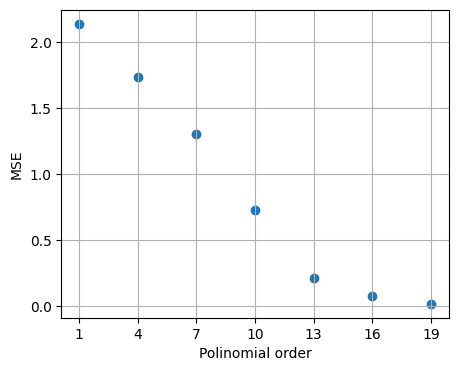

In [18]:
fig = plt.figure(figsize=(5,4))
plt.scatter(range(1, 20, 3),losses)
plt.xticks(range(1, 20, 3))
plt.xlabel("Polinomial order")
plt.ylabel("MSE")
plt.grid()
plt.show()

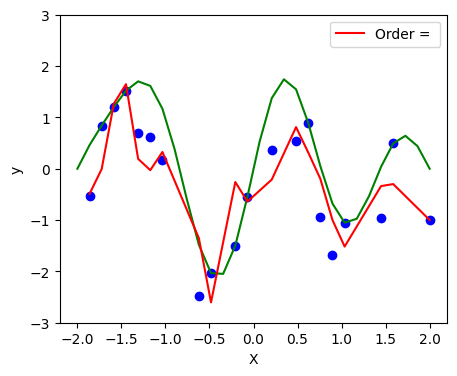

In [99]:
p=9

A = make_design(torch.reshape(trainingX, (20, 1)), gaussian_basis_fn, torch.linspace(-2,2,p))
lam = 0 #regularization parameter
theta = regression(A, lam, p, trainingY)
predictions = A @ theta.T

torch.nn.functional.mse_loss(predictions,trainingX)

fig = plt.figure(figsize=(5,4))
plt.ylim(-3,3)
plt.xlabel("X")
plt.ylabel("y")
plt.plot(X, f(X), c="green")
plt.scatter(trainingX, trainingY,c = "blue")
plt.plot(trainingX, predictions, c="red", label = "Order = ")
# plt.plot(trainingX, predictions, c="orange", label = "lnλ = -18")
# plt.plot(trainingX, A.dot(weight.T), c="orange", label = "predictions for minimized weights")
plt.legend()

(20,)
(20, 2)
(20, 3)
(20, 4)
(20, 5)
(20, 6)
(20, 7)
(20, 8)
(20, 9)
(20, 10)
(20, 11)


/var/folders/d_/7s822lfj1tjgdlqm3b8yj60w0000gn/T/ipykernel_39482/1924127319.py:32: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(lam),rmseTraining, c="blue", label= "Training")


ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

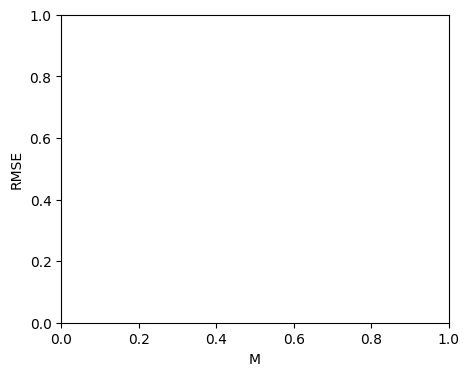

In [58]:
ms = torch.linspace(1,10,10)
# print(ms)
# lam = torch.linspace(-20,0,15)
# lam = torch.exp(lam)

# print(rmse(A,trainingY,w.T))
rmseTraining = []
rmseTesting = []
print(trainingY.shape)
for i in range(1,11):
#   A = np.stack([polynomial_basis_fn(trainingX,j) for j in range (0,p + 1)], axis = 1)
#   w = regression(A, lam[i], p, trainingY)
#   rmseTraining.append(rmse(A,trainingY,w.T))

#   A = np.stack([polynomial_basis_fn(testingX,j) for j in range (0,p + 1)], axis = 1)
#   w = regression(A, lam[i], p, testingY)
#   rmseTesting.append(rmse(A,testingY,w.T))

  A = make_design(torch.reshape(trainingX, (20, 1)), gaussian_basis_fn, torch.linspace(-2,2,i))
  print(A.shape)
  w = regression(A, lam, i, trainingY)
  rmseTraining.append(rmse(A,trainingY,w.T))

  A = make_design(torch.reshape(testingX, (10, 1)), gaussian_basis_fn, torch.linspace(-2,2,i))
  w = regression(A, lam, i, testingY)
rmseTesting.append(rmse(A,testingY,w.T))

fig = plt.figure(figsize=(5,4))
# plt.ylim(-3,3)
plt.xlabel("M")
plt.ylabel("RMSE")
plt.plot(np.log(lam),rmseTraining, c="blue", label= "Training")
plt.plot(np.log(lam),rmseTesting, c="red", label = "Testing")
plt.scatter(np.log(lam),rmseTraining, c="blue")
plt.scatter(np.log(lam),rmseTesting, c="red")
plt.legend()

In [168]:
def rotate(angle, w):
  theta = np.radians(angle)
  R = [[np.cos(theta), -torch.sin(theta)], [torch.sin(theta), np.cos(theta)]]
  return(np.dot(R,w))

def fisherScore(yA, yB):
  mA = np.average(yA)
  mB = np.average(yB)
  varA = np.var(yA)
  varB = np.var(yB)
  betweenVar = (mB - mA) ** 2
  propA = len(yA)/(len(yA) + len(yB))
  propB = len(yB)/(len(yA) + len(yB))
  # withinVar = propA * varA + propB * varA
  withinVar = propA * varA + propB * varB

  return betweenVar/withinVar

print(fisherScore(yA1,yB1))

def fisherRotation(degrees, w):
  score = []
  for theta in degrees:
    newW = rotate(theta, w)
    yA = getY(newW, x1A, x2A)
    yB = getY(newW, x1B, x2B)
    s = fisherScore(yA, yB)
    score.append(s)
  return score

def optimalW(fScore, ogW, maxW):
  optimal = []
  for i in range(len(fScore)):
    # print(fScore[i] , rotate(i, ogW) )
    if fScore[i] == maxW:
      optimal = rotate(i, ogW)
  return optimal

# print(fisher_score.fisher_score(A,xA[0]))


NameError: name 'yA1' is not defined

4.395417557919539 [-0.87067681 -1.1144155 ]


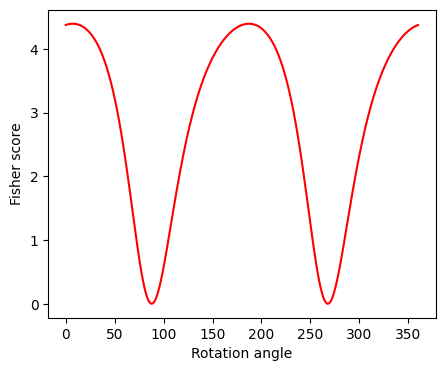

In [ ]:
degrees = [i for i in range(0,361)]

# print(fisherRotation(degrees, w1))

fig = plt.figure(figsize=(5,4))
plt.xlabel('Rotation angle')
plt.ylabel('Fisher score')
# plt.plot(degrees, fisherRotation(degrees, w1), c='blue')
plt.plot(degrees, fisherRotation(degrees, w2), c="red")

maxScore2 = np.max(fisherRotation(degrees, w2))

# print(score1)
# print(maxScore1)
# print(optimalW(fisherRotation(degrees, w1), w1, maxScore1))
# print(maxScore1, optimalW(fisherRotation(degrees, w1), w1, maxScore1))
print(maxScore2, optimalW(fisherRotation(degrees, w2), w2, maxScore2))